# Deployable Payload Flight Simulation Example

Today we try to demonstrate how to use RocketPy to simulate a flight of a rocket
that presents a deployable payload.

To run this notebook, we will need:

*   RocketPy
*   netCDF4 (to get weather forecasts)
*   Data files (we will clone RocketPy's repository for these)

Therefore, let's run the following lines of code:

In [ ]:
!pip install rocketpy netCDF4
!git clone https://github.com/RocketPy-Team/RocketPy.git

In [ ]:
import os

os.chdir("RocketPy/docs/notebooks")

Now we can start!

Here we go through a simplified rocket trajectory simulation to get you started. Let's start by importing the rocketpy module.

In [31]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, Function

If you are using a version of Jupyter Notebooks, it is recommended to run the following lines of code to make plots which will be shown later interactive and/or higher quality.

In [32]:
# Using Google Colab? Uncomment the following line:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# Using Jupyter Notebook/Lab or VSCode? Uncomment the following line:
# %matplotlib widget

## Setting Up a Simulation

### Creating an Environment for Spaceport America

In [33]:
Env = Environment(
    railLength=5.2, latitude=32.990254, longitude=-106.974998, elevation=1400
)

To get weather data from the GFS forecast, available online, we run the following lines.
See [Environment Class Usage](environment_class_usage.ipynb) for more information on how to use the Environment class.

In [34]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

Env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time

Env.setAtmosphericModel(type="Forecast", file="GFS")
Env.maxExpectedHeight = 8000

Launch Site Details

Launch Rail Length: 5.2  m
Launch Date: 2022-10-06 12:00:00 UTC
Launch Site Latitude: 32.99025°
Launch Site Longitude: -106.97500°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 315468.64 W    3651938.65 N
Launch Site UTM zone: 13S
Launch Site Surface Elevation: 1471.5 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 8.000 km
Forecast Time Period: From  2022-10-05 06:00:00  to  2022-10-21 06:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 4.03 m/s
Surface Wind Direction: 61.94°
Surface Wind Heading: 182.37°
Surface Pressure: 858.27 hPa
Surface Temperature: 287.78 K
Surface Air Density: 1.039 kg/m³
Surface Speed of Sound: 340.08 m/s


Atmospheric Model Plots


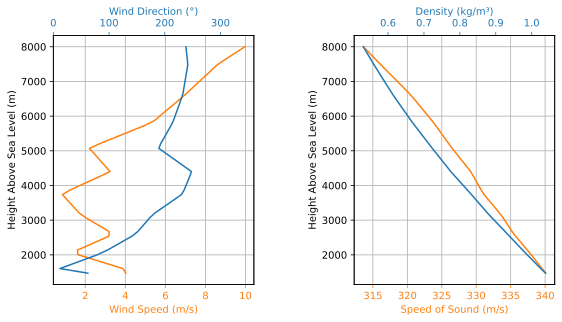

In [35]:
Env.info()

### Creating a Motor

A solid rocket motor is used in this case. See [Solid Motor Class Usage](solid_motor_class_usage.ipynb) for more information on how to use the Motor class.

In [36]:
Pro75M1670 = SolidMotor(
    thrustSource="../../data/motors/Cesaroni_M1670.eng",
    burnOut=3.9,
    grainNumber=5,
    grainSeparation=5 / 1000,
    grainDensity=1815,
    grainOuterRadius=33 / 1000,
    grainInitialInnerRadius=15 / 1000,
    grainInitialHeight=120 / 1000,
    nozzleRadius=33 / 1000,
    throatRadius=11 / 1000,
    interpolationMethod="linear",
)


Motor Details
Total Burning Time: 3.9 s
Total Propellant Mass: 2.956 kg
Propellant Exhaust Velocity: 2038.745 m/s
Average Thrust: 1545.218 N
Maximum Thrust: 2200.0 N at 0.15 s after ignition.
Total Impulse: 6026.350 Ns

Plots


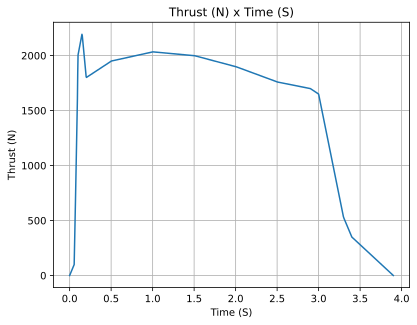

In [37]:
Pro75M1670.info()

## Simulating the First Flight Stage

Let's start to simulate our rocket's flight. We will use the Environment and Motor objects we created before.

We will assume that the payload is be ejected at apogee, however, this can be modified if needed.

We start by defining the value of each relevant mass, ensuring the are correct before continuing.

In [48]:
# 16.241 is the mass of the rocket including the payload but without the propellant
PayloadMass = 4.5  # in kg
RocketMass = 16.241 - PayloadMass  # in kg

print("Rocket dry mass: {:.4} kg (with Payload)".format(RocketMass + PayloadMass))
print("Propellant Mass: {:.4} kg".format(Pro75M1670.mass(0)))
print("Payload Mass: {:.4} kg".format(PayloadMass))
print(
    "Fully loaded Rocket Mass: {:.4} kg".format(
        RocketMass + Pro75M1670.mass(0) + PayloadMass
    )
)

Rocket dry mass: 16.24 kg (with Payload)
Propellant Mass: 2.956 kg
Payload Mass: 4.5 kg
Fully loaded Rocket Mass: 19.2 kg


In [49]:
Rocket1 = Rocket(
    motor=Pro75M1670,
    radius=127 / 2000,
    mass=RocketMass + PayloadMass,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="../../data/calisto/powerOffDragCurve.csv",
    powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
)

Rocket1.setRailButtons([0.2, -0.5])

NoseCone_Rocket1 = Rocket1.addNose(
    length=0.55829, kind="vonKarman", distanceToCM=0.71971
)

FinSet_Rocket1 = Rocket1.addFins(
    4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
)

Tail_Rocket1 = Rocket1.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)

Inertia Details
Rocket Dry Mass: 16.241 kg (No Propellant)
Rocket Total Mass: 19.196911961392022 kg (With Propellant)

Geometrical Parameters
Rocket Radius: 0.0635 m

Aerodynamics Stability
Initial Static Margin: 2.051 c
Final Static Margin: 3.090 c

Aerodynamics Plots


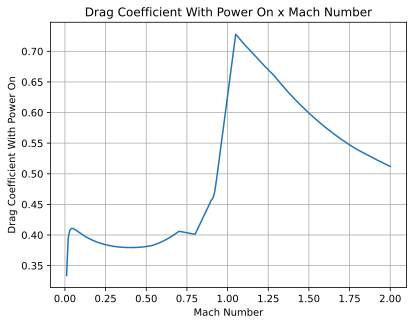

In [50]:
Rocket1.info()

In [51]:
RocketFlight1 = Flight(
    rocket=Rocket1, environment=Env, inclination=85, heading=25, terminateOnApogee=True
)

## Start the Second Flight Stage

Now we will simulate the second flight stage, which is the landing phase of our Rocket.
Here we will consider that the payload was ejected at the apogee of the first stage.
Therefore we should be careful with the value of its mass.

In [52]:
Rocket2 = Rocket(
    motor=Pro75M1670,  # This motor will not be used
    radius=127 / 2000,
    mass=RocketMass,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag=1,
    powerOnDrag=1,
)


def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False


def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
    return True if y[5] < 0 and y[2] < 800 + 1400 else False


# Define Parachutes for the rocket
Main_Rocket2 = Rocket2.addParachute(
    "Main",
    CdS=7.2,
    trigger=mainTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue_Rocket2 = Rocket2.addParachute(
    "Drogue",
    CdS=0.72,
    trigger=drogueTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Inertia Details
Rocket Dry Mass: 11.741 kg (No Propellant)
Rocket Total Mass: 14.696911961392022 kg (With Propellant)

Geometrical Parameters
Rocket Radius: 0.0635 m

Aerodynamics Stability
Initial Static Margin: -1.357 c
Final Static Margin: -0.000 c

Main Parachute
CdS Coefficient: 7.2 m2

Drogue Parachute
CdS Coefficient: 0.72 m2

Aerodynamics Plots


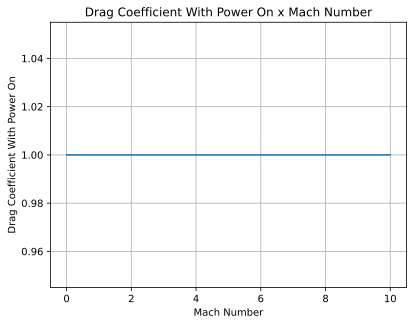

In [53]:
Rocket2.info()

The magic line `initialSolution=RocketFlight1` will make the simulation start from the end of the first stage.

In [54]:
RocketFlight2 = Flight(
    rocket=Rocket2,
    environment=Env,
    inclination=0,
    heading=0,
    maxTime=600,
    initialSolution=RocketFlight1,
)

## Simulating the 3 Flight Stage - Payload Flight

Here we will simulate the payload flight, which is the third flight stage of our Rocket.
The Payload will be ejected at the apogee of the first stage.
Here, it will be modelled as a "dummy" rocket, which does not have any aerodynamic surfaces to stabilize it, neither a motor which ignites.
It does, however, have parachutes.

In [55]:
# Define the "Payload Rocket"

PayloadRocket = Rocket(
    motor=Pro75M1670,  # This motor will not be used
    radius=127 / 2000,
    mass=PayloadMass,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag=0.5,
    powerOnDrag=0.5,
)


def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False


def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
    return True if y[5] < 0 and y[2] < 800 + 1400 else False


PayloadDrogue = PayloadRocket.addParachute(
    "Drogue",
    CdS=0.35,
    trigger=drogueTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

PayloadMain = PayloadRocket.addParachute(
    "Main",
    CdS=4.0,
    trigger=mainTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

The magic line `initialSolution=RocketFlight1` will make the simulation start from the end of the first stage.

In [56]:
PayloadFlight = Flight(
    rocket=PayloadRocket,
    environment=Env,
    inclination=0,
    heading=0,
    maxTime=600,
    initialSolution=RocketFlight1,
)

## Plotting Everything together

We will invoke a method from RocketPy's flight_plots module in order to visualize 
the trajectory.

In [57]:
from rocketpy.plots import flight_plots

By initializing the flight_plots class, we can plot the trajectory ad other
important information about the flights. 

In [19]:
flight_plotter = flight_plots.flight_plots(
    trajectory_list=[RocketFlight1, RocketFlight2, PayloadFlight],
    names_list=["Rocket - 1st Stage", "Rocket - 2nd Stage", "Payload"],
)

Numerical information are available by calling `.info()` method.

In [37]:
flight_plotter.info()


Initial Conditions for Flight:  Rocket - 1st Stage
Position - x: 0.00 m | y: 0.00 m | z: 1471.47 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.975 | e1: -0.043 | e2: 0.009 | e3: -0.216
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: -25.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s

Initial Conditions for Flight:  Rocket - 2nd Stage
Position - x: 39485.37 m | y: 133869.35 m | z: 4345914.80 m
Velocity - Vx: -191.43 m/s | Vy: -723.16 m/s | Vz: -47595.99 m/s
Attitude - e0: -67496.659 | e1: 63232.013 | e2: -4205.673 | e3: 15122.327
Euler Angles - Spin φ : -8.82° | Nutation θ: -84.72° | Precession ψ: -16.43°
Angular Velocity - ω1: -0.35 rad/s | ω2: -0.05 rad/s| ω3: 0.00 rad/s

Initial Conditions for Flight:  Payload
Position - x: 51501.13 m | y: 174607.13 m | z: 4349500.80 m
Velocity - Vx: -176.89 m/s | Vy: -685.68 m/s | Vz: -62960.94 m/s
Attitude - e0: -67498.155 | e1: 63230.993 | e2: -4205.605 | e3: 15122.661
Euler An

We will mode straight forward and plot all the available charts at once by
calling the `.allInfo()` method. But you can also plot each chart individually
by calling any of the following methods:
- `.compareFlightTrajectories3D()`
- `.compareVelocities()`
- `.compareAerodynamicForces()`
- `.compareStaticMargins()`
-  etc.

You can use `dir(flight_plotter)`to check all the available methods.

Compare mode not yet implemented
Initial Conditions for Flight:  Rocket - 1st Stage
Position - x: 0.00 m | y: 0.00 m | z: 1471.47 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 0.975 | e1: -0.043 | e2: 0.009 | e3: -0.216
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: -25.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s 

Initial Conditions for Flight:  Rocket - 2nd Stage
Position - x: 39485.37 m | y: 133869.35 m | z: 4345914.80 m
Velocity - Vx: -191.43 m/s | Vy: -723.16 m/s | Vz: -47595.99 m/s
Attitude - e0: -67496.659 | e1: 63232.013 | e2: -4205.673 | e3: 15122.327
Euler Angles - Spin φ : -8.82° | Nutation θ: -84.72° | Precession ψ: -16.43°
Angular Velocity - ω1: -0.35 rad/s | ω2: -0.05 rad/s| ω3: 0.00 rad/s 

Initial Conditions for Flight:  Payload
Position - x: 51501.13 m | y: 174607.13 m | z: 4349500.80 m
Velocity - Vx: -176.89 m/s | Vy: -685.68 m/s | Vz: -62960.94 m/s
Attitude - e0: -67498.155 | e1: 63230.993 | e2: 

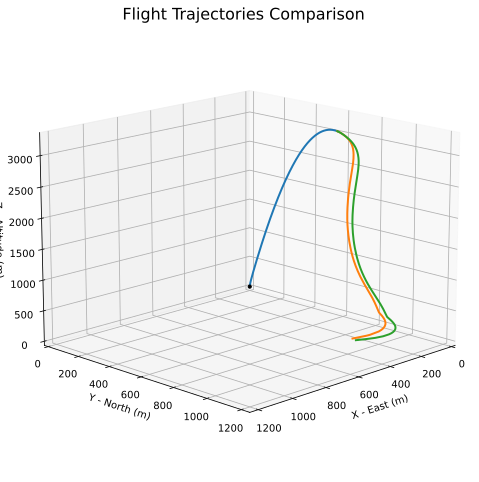

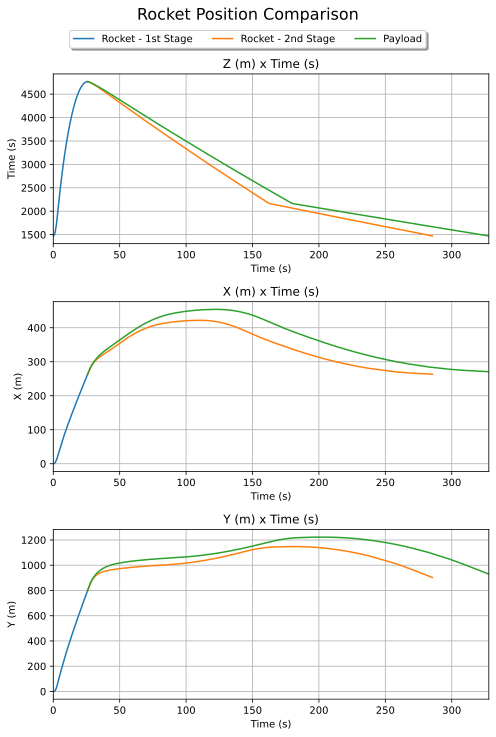

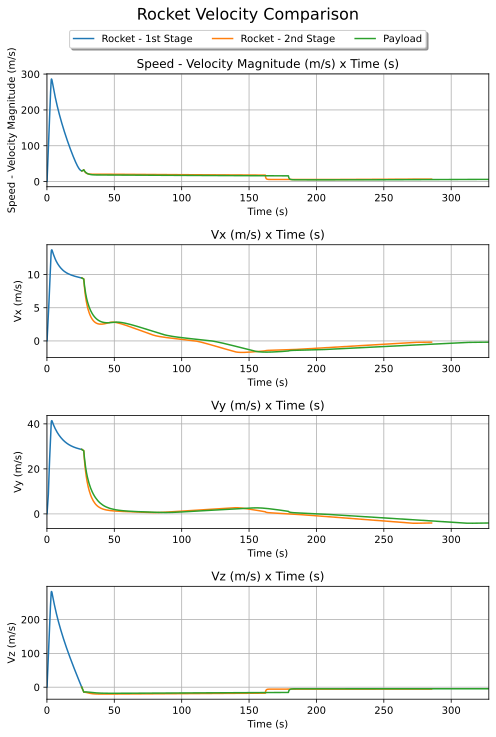

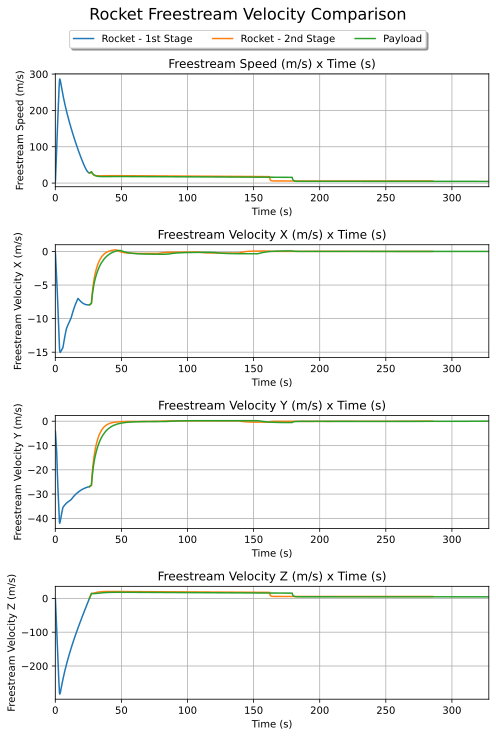

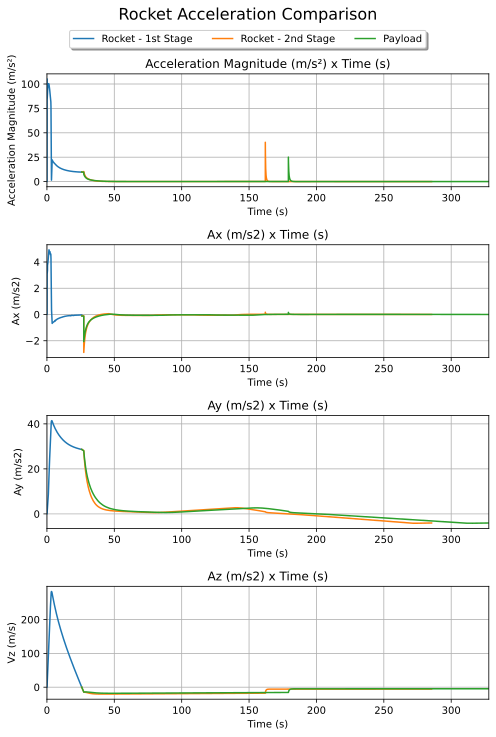

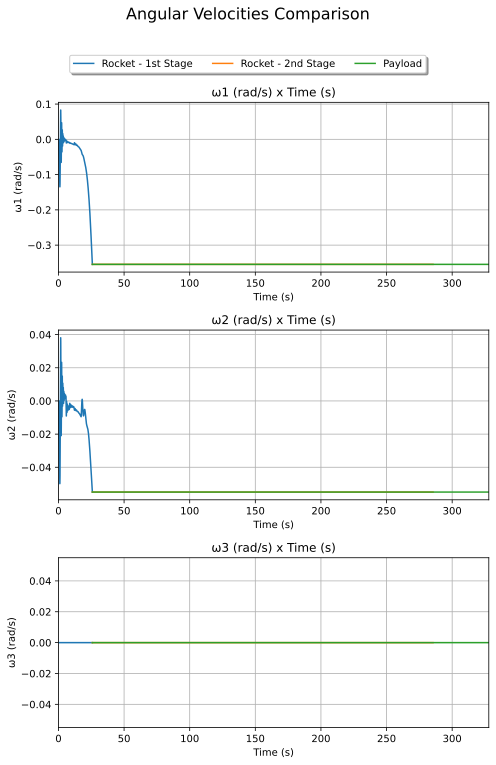

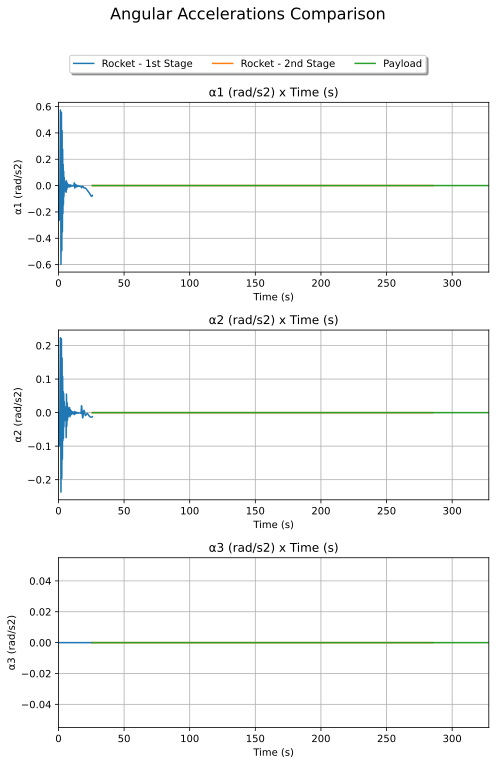

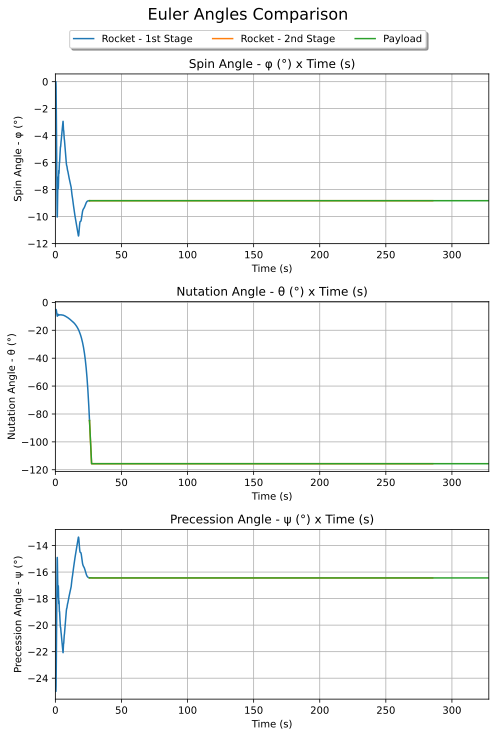

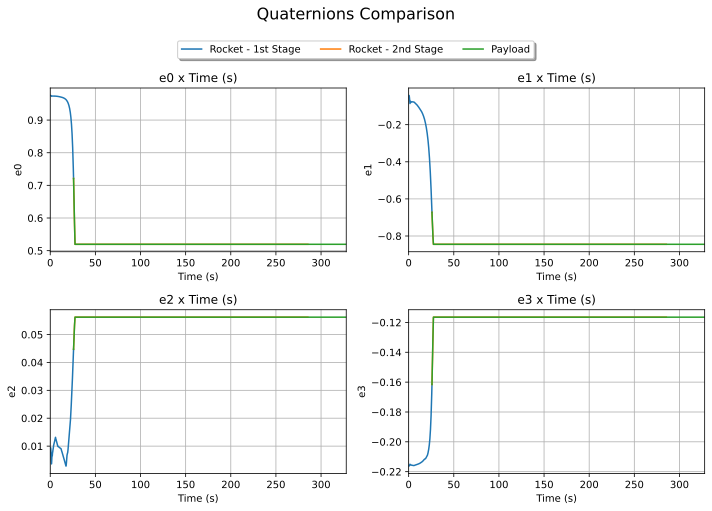

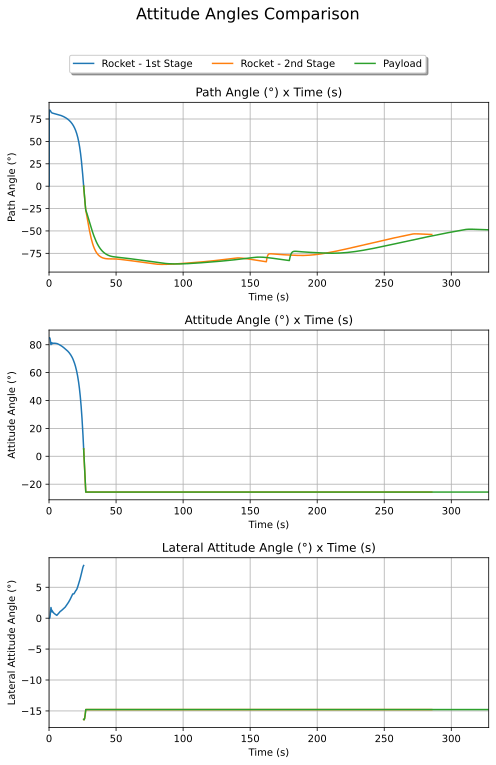

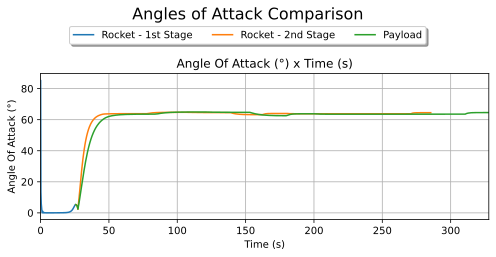

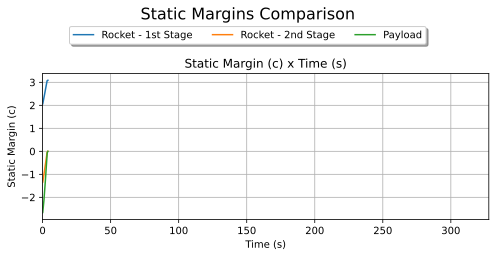

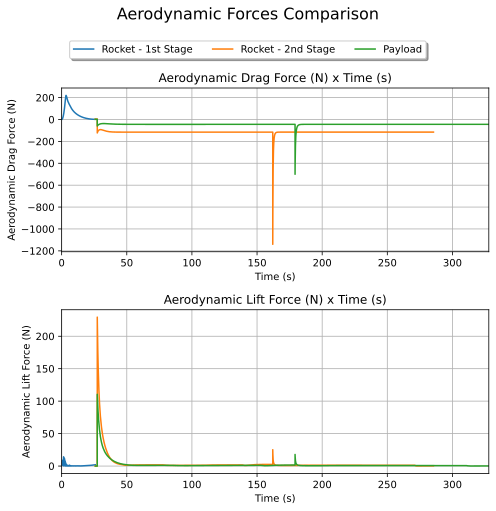

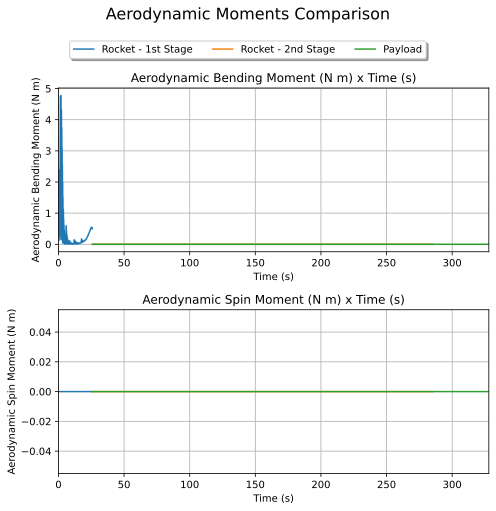

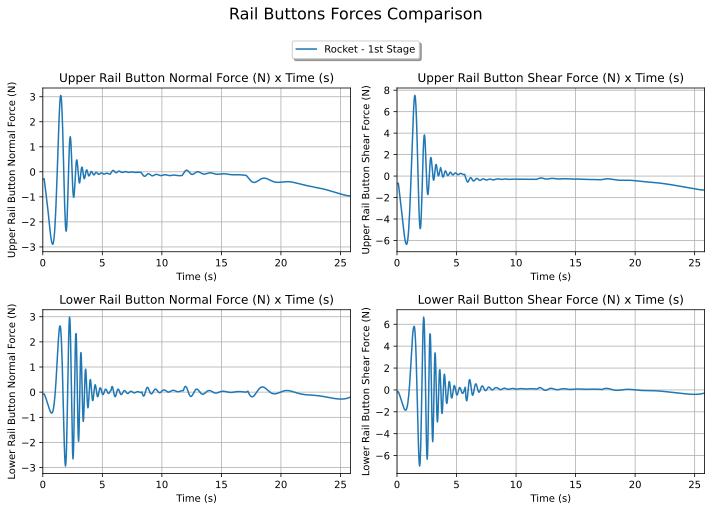

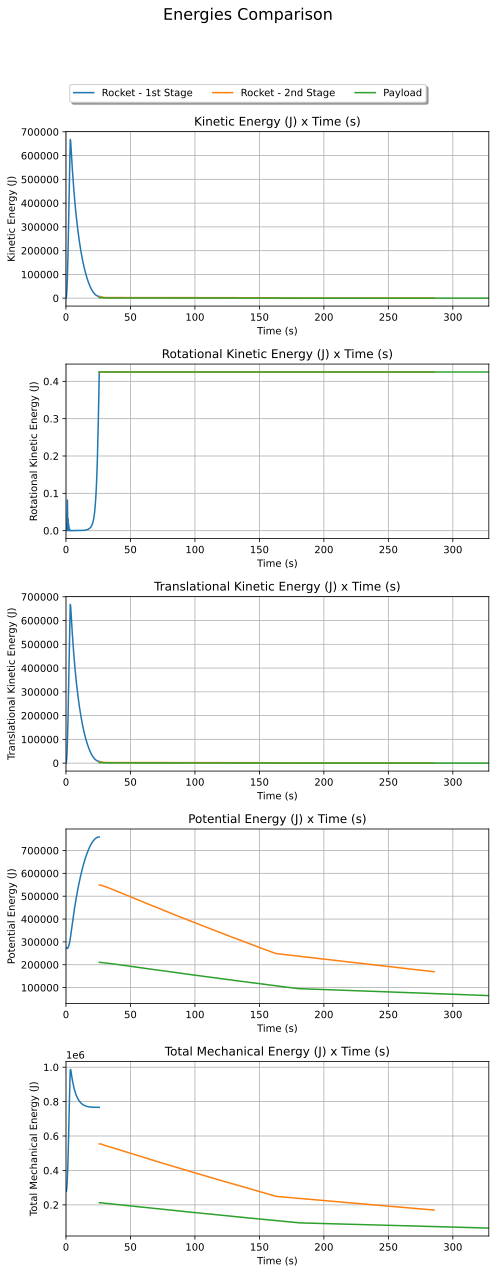

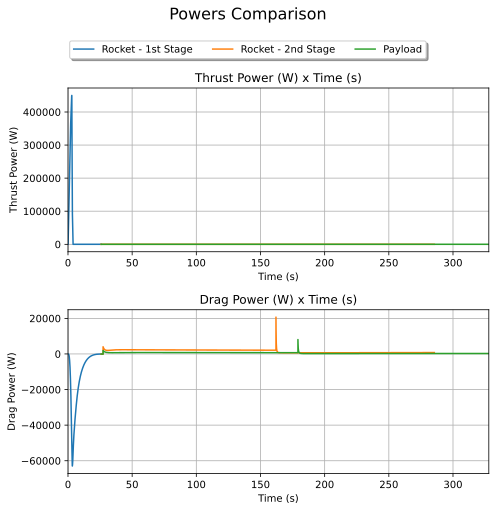

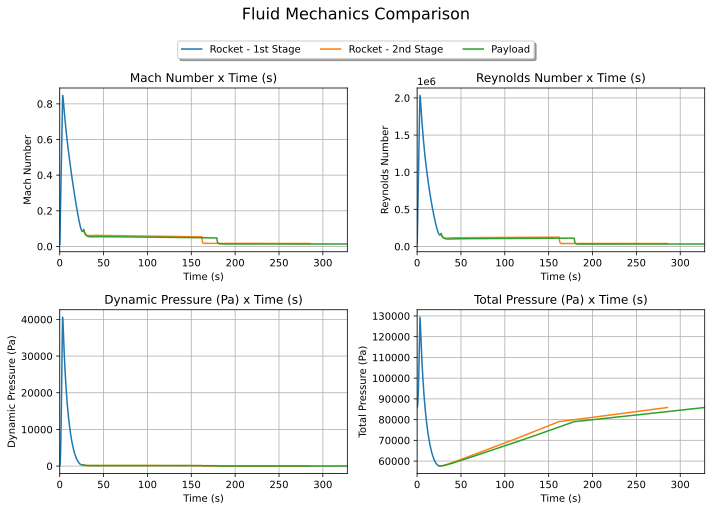

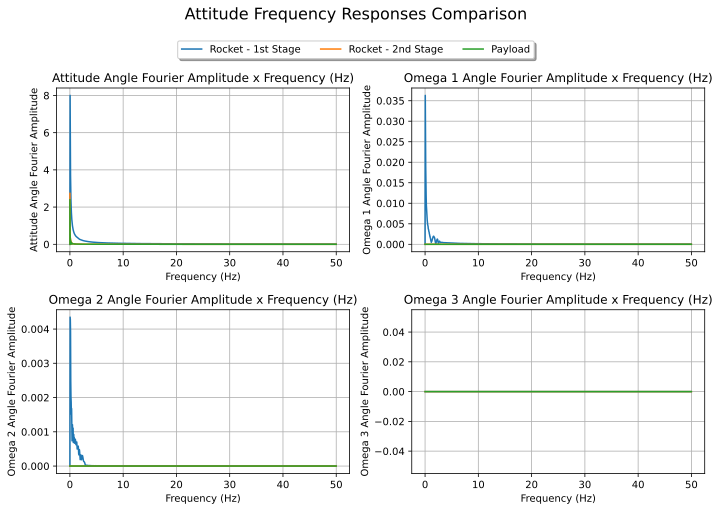

In [34]:
flight_plotter.allInfo(mode="compare")

In [28]:
type(RocketFlight2.rocket.railButtons)

NoneType

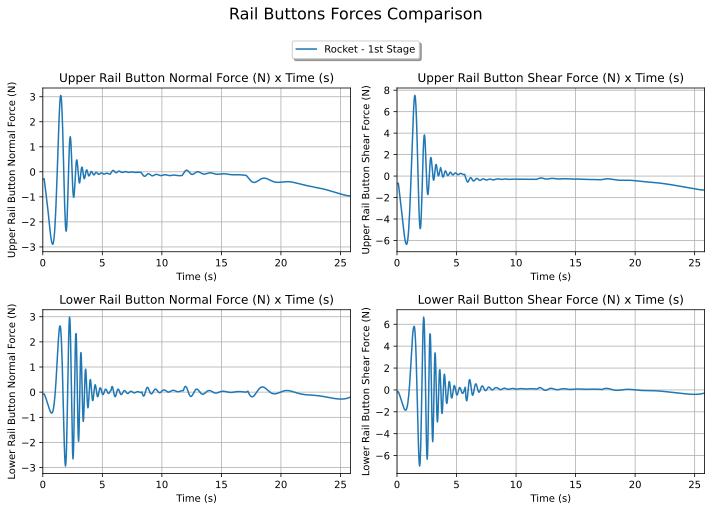

In [33]:
flight_plotter.compareRailButtonsForces()